## Regression analysis of seagrass carbon dataset

Summary version of regression notebook to share with Regen and Chris to improve random forest analysis <br> 

**Aim of analysis**: to create a predictive model of carbon for seagrass beds using regression ML methods

This notebook runs through the analysis starting with tidying the data and preprocessing the data, removing correlating variables with encoding of categorical data.  The analysis starts with multiple linear regression to understand the data at it's simplest. Then boosted regression tree, decision tree regressor and random forest regressor are tried with their associated means of visualising the feature importances and tree structure. <br> The outcome is that the regressors overfit to the training data but massively underperform on the test data. This could be due to the size of the dataset (n = 174) with a 80:20 test-train split or that the variables are not predictive. I think the problem is the former as the multiple regression shows that a number of the variables are predictive. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from functools import reduce
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

In [2]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices, dmatrix, demo_data
from scipy.optimize import basinhopping
import scipy.stats as stats
from sklearn.metrics import mean_squared_error as MSE
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.inspection import permutation_importance
from sklearn.tree import plot_tree
from scipy import stats

## 1. Import Data

In [3]:
## Import carbon data
path = r"C:\Users\nw431\OneDrive - University of Exeter\1_PhD Research\Project1_Carbon Model\Seagrass env variables\1E_Final dataset\Outputs\final_dataset.csv"
df = pd.read_csv(path, index_col = 0)

## 2. Tidy data

Removes columns that are not relevant to include in analysis and remove variables that are correlated (set up for an iterative process as check below). Reduce to just Z. marina or Z. marina mixed beds (other species removed as not enough samples). Finally remove any NaN samples

In [4]:
#drop rows with nan in long/lat column to remove with no data
df = df[df['Lat'].notna()]
#rename species to combine Z. marina mixed to one 
df['Species'].replace({'Z. marina/Z. angustifolia/Z. noltii/Ruppiaspp.': 'Z. marina mixed', 'Z. marina/Z. noltii': 'Z. marina mixed'}, inplace = True)
#df['Species'].unique()

#drop REALM, Site_name, Mono-mix (as unvegetated within species) - unncesssary columns
df = df.drop(['Site_name', 'Mono_mix', 'REALM', 'C25_SD', 'ECO_CODE', 'PROV_CODE',
       'RLM_CODE', 'land_cover_class'], axis =1)
df = df.rename({'forest%': 'forest_pc', 'soil_clay%': 'soil_clay_pc', 'soil_silt%': 'soil_silt_pc', 'soil_sand%': 'soil_sand_pc'}, axis='columns')

C:\Users\nw431\AppData\Local\Temp\ipykernel_3068\1361108039.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr(),


<Axes: >

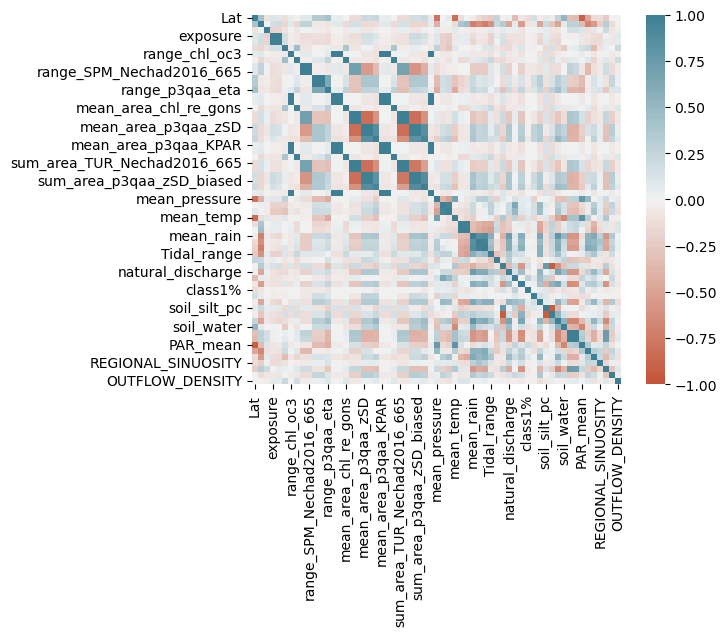

In [5]:
sns.heatmap(
    df.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

In [12]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'uint8']
print("Top Absolute Correlations")
print(get_top_abs_correlations(df.select_dtypes(include = numerics), 20))
#print(get_redundant_pairs(df))

Top Absolute Correlations
mean_area_TUR_Nechad2016_665  mean_area_SPM_Nechad2016_665    1.000000
sum_area_TUR_Nechad2016_665   sum_area_SPM_Nechad2016_665     1.000000
range_TUR_Nechad2016_665      range_SPM_Nechad2016_665        1.000000
mean_area_p3qaa_KPAR          sum_area_p3qaa_KPAR             1.000000
range_p3qaa_KPAR              mean_area_p3qaa_KPAR            1.000000
                              sum_area_p3qaa_KPAR             1.000000
mean_area_chl_oc3             sum_area_chl_oc3                1.000000
range_chl_oc3                 mean_area_chl_oc3               0.999984
                              sum_area_chl_oc3                0.999984
sum_area_p3qaa_zSD            sum_area_p3qaa_zSD_biased       0.999947
mean_area_p3qaa_zSD           mean_area_p3qaa_zSD_biased      0.999947
mean_area_chl_re_gons         sum_area_chl_re_gons            0.999684
range_p3qaa_zSD               range_p3qaa_zSD_biased          0.999451
range_chl_oc3                 sum_area_p3qaa_KPAR  

Due to correlation of variables above select uncorrelated columns of interest for regression. 

In [13]:
#due to correlation of variables above select uncorrelated columns of interest for regression
reg_cols = ['Cstock25_Mgha','Lat', 'exposure', 'Species', 'extr_exposure', 'ECOREGION', 'PROVINCE', 'NEAR_DIST', 'mean_area_TUR_Nechad2016_665',
       'mean_area_SPM_Nechad2016_665', 'mean_area_p3qaa_zSD', 'mean_area_p3qaa_eta', 'mean_pressure', 'mean_temp',
        'soil_clay_pc', 'soil_erosion', 'soil_water', 'hfi_93', 'hfi_09',
       'soil_silt_pc', 'soil_sand_pc', 'soil_carbon_stock', 'PAR_mean', 'forest_pc', 'MEAN_SIG_WAVEHEIGHT', 
        'REGIONAL_SINUOSITY', 'GHM', 
       'OUTFLOW_DENSITY', 'mean_rain', 'Tidal_range', 'ERODIBILITY', 'TEMP_MOISTURE','EMU_PHYSICAL',]

df = df.loc[:, reg_cols]

#cols to remove due to correlation (tested below - iterative process)
corr_cols = ['mean_area_TUR_Nechad2016_665', 'mean_area_SPM_Nechad2016_665', 'PROVINCE', 'hfi_09', 'hfi_93', 'extr_exposure', 'Lat', 'mean_area_p3qaa_eta', 'soil_clay_pc', 'soil_sand_pc', 'mean_temp', 'ECOREGION']
df = df.drop(corr_cols, axis =1)

# use only Z.marina data - remove species cat
zmarina = ['Z. marina', 'Z. marina mixed']
df = df[df['Species'].isin(zmarina)]
df = df.drop('Species', axis = 1)

#drop any remaining nans
df = df.dropna(how='any')
df.shape

(175, 20)

## 3. Preprocessing 

### Encode categorical data

**Resources:** LabelEncoder (doesn't have order)- https://www.geeksforgeeks.org/how-to-convert-categorical-features-to-numerical-features-in-python <br>   Ordinal Encoder: https://towardsdatascience.com/preprocessing-with-sklearn-a-complete-and-comprehensive-guide-670cb98fcfb9

Ordinal Encoder used to encode Erodibilty variable and label encoder to encode climatic variables

In [14]:
#print the unique values
df.ERODIBILITY.unique()

array(['High', 'Medium', 'Low', 'Non'], dtype=object)

In [15]:
df_encoded = df.copy() #create a copy to encode on
enc = OrdinalEncoder(categories = [['Non', 'Low', 'Medium', 'High']])
df_encoded.ERODIBILITY = enc.fit_transform(df_encoded.loc[:,['ERODIBILITY']]) #fit transform

In [16]:
cat_cols = df_encoded.select_dtypes(include=object).columns.tolist() 
print('categorical columns to encode with label encoder', cat_cols)
#label encoder on categorical columns
df_encoded[cat_cols] = df_encoded[cat_cols].apply(LabelEncoder().fit_transform)
#drop cat cols or select numeric columns only
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'uint8']
df = df_encoded.select_dtypes(include = numerics)
print('df shape', df.shape)

categorical columns to encode with label encoder ['TEMP_MOISTURE', 'EMU_PHYSICAL']
df shape (175, 20)


In [17]:
#drop nan rows
df = df.dropna(how='any')
#drop outlier in cstock
outlier = df[df['Cstock25_Mgha'] > 250].index
df = df.drop(outlier)
df.shape

(174, 20)

In [18]:
print('Final dataframe variables: ', df.keys().tolist())

Final dataframe variables:  ['Cstock25_Mgha', 'exposure', 'NEAR_DIST', 'mean_area_p3qaa_zSD', 'mean_pressure', 'soil_erosion', 'soil_water', 'soil_silt_pc', 'soil_carbon_stock', 'PAR_mean', 'forest_pc', 'MEAN_SIG_WAVEHEIGHT', 'REGIONAL_SINUOSITY', 'GHM', 'OUTFLOW_DENSITY', 'mean_rain', 'Tidal_range', 'ERODIBILITY', 'TEMP_MOISTURE', 'EMU_PHYSICAL']


In [19]:
#print nan df to check no nans left
df[df.isna().any(axis =1)]

,Cstock25_Mgha,exposure,NEAR_DIST,mean_area_p3qaa_zSD,mean_pressure,soil_erosion,soil_water,soil_silt_pc,soil_carbon_stock,PAR_mean,forest_pc,MEAN_SIG_WAVEHEIGHT,REGIONAL_SINUOSITY,GHM,OUTFLOW_DENSITY,mean_rain,Tidal_range,ERODIBILITY,TEMP_MOISTURE,EMU_PHYSICAL


### Split train and test set

In [20]:
X = df.drop(['Cstock25_Mgha'], axis = 1)
y = df.loc[:, 'Cstock25_Mgha']
#log y
y_log = np.log(y)
#split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) #80:20 split to train test set

In [21]:
print('X shape: ', X.shape)
print('y shape: ', y.shape)

X shape:  (174, 19)
y shape:  (174,)


## 4. Visualise data

Visualise data before continue with analysis. Due to size of whole dataset, only a subsection is shown on pairplots

C:\Users\nw431\Miniconda3\envs\sklearn\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


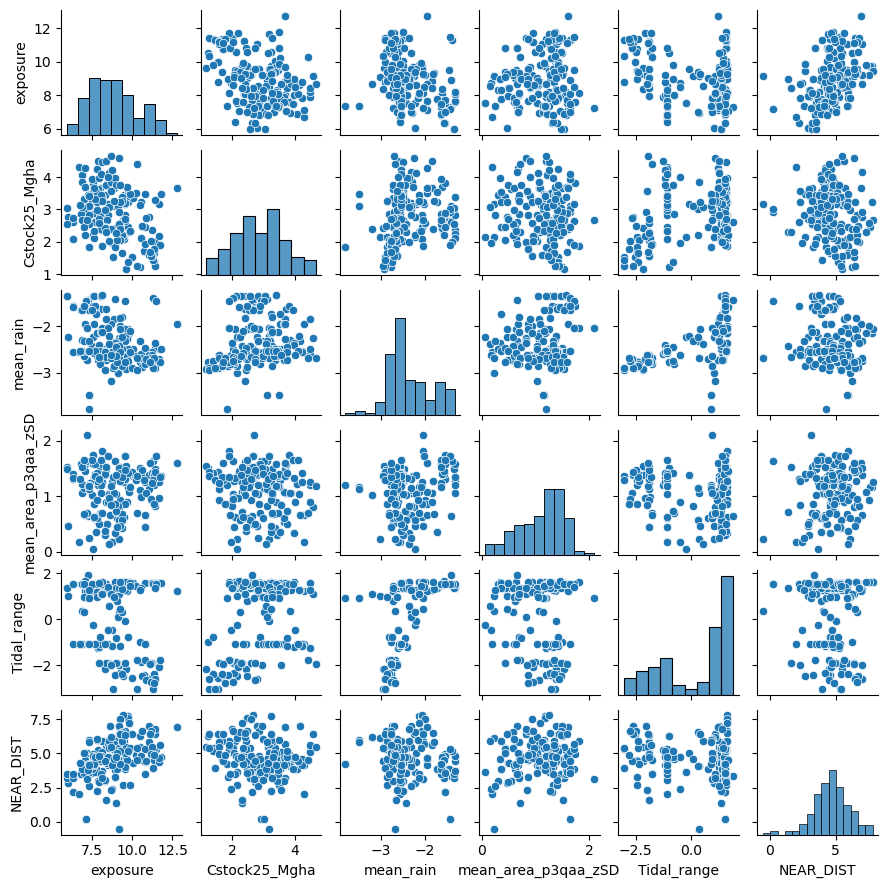

In [22]:
#viz on df_all
df_viz = df[['exposure', 'Cstock25_Mgha', 'mean_rain','mean_area_p3qaa_zSD', 'Tidal_range', 'NEAR_DIST']]
df_viz = np.log(df_viz) #log whole dataset
sns.pairplot(df_viz, height=1.5);

Check there are not any overly correlated variables remaining


<Axes: >

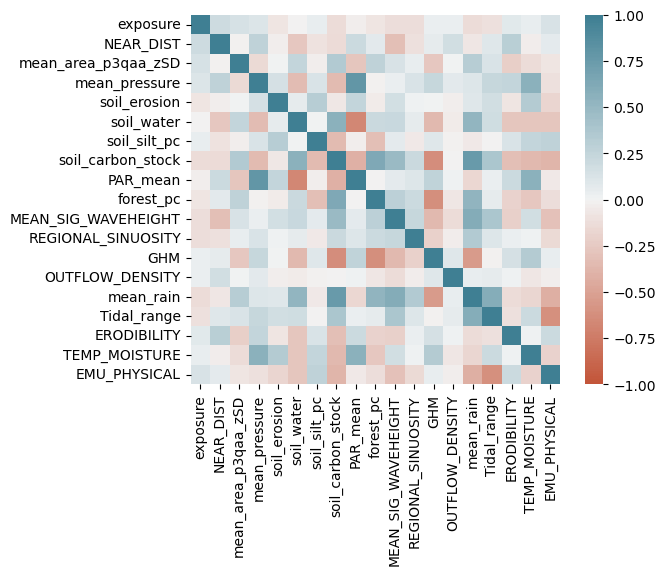

In [23]:
sns.heatmap(
    X.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

Check top correlated pairs

In [24]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(X, 10))

Top Absolute Correlations
mean_pressure        PAR_mean             0.790219
soil_carbon_stock    mean_rain            0.757790
soil_water           PAR_mean             0.677857
soil_carbon_stock    forest_pc            0.630162
                     GHM                  0.627506
forest_pc            GHM                  0.617298
Tidal_range          EMU_PHYSICAL         0.616453
MEAN_SIG_WAVEHEIGHT  mean_rain            0.603973
mean_rain            Tidal_range          0.588257
soil_water           soil_carbon_stock    0.568580
dtype: float64


## 5. Multiple linear regression

Initially run multiple linear regression with sklearn to understand the dataset

In [25]:
#use statsmodels for detailed regression 
X_const = sm.add_constant(X)  #allows nonzero intercept
model_lr = sm.OLS(y_log, X_const).fit()
res = model_lr.resid #residuals

In [26]:
model_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Cstock25_Mgha   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     4.784
Date:                Thu, 05 Oct 2023   Prob (F-statistic):           1.24e-08
Time:                        11:22:30   Log-Likelihood:                -166.91
No. Observations:                 174   AIC:                             373.8
Df Residuals:                     154   BIC:                             437.0
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  68.6215     87.169      0.787      0.432    -103.579     240.822
exposure            -4.068e-06   1.53e-06     -2.658      0.009   -7.09e-06   -1.04e-06
NEAR_DIST               0.0001      0.000      0.591      0.555      -0.000       0.000
mean_area_p3qaa_zSD    -0.0177      0.048     -0.366      0.715      -0.113       0.078
mean_pressure          -0.0007      0.001     -0.813      0.418      -0.002       0.001
soil_erosion           -0.0002      0.000     -1.754      0.081      -0.000     2.4e-05
soil_water              0.0296      0.009      3.229      0.002       0.012       0.048
soil_silt_pc            0.0369      0.017      2.155      0.033       0.003       0.071
soil_carbon_stock       0.0015      0.003      0.533      0.595      -0.004       0.007
PAR_mean                0.0349      0.016      2.123      0.035       0.002       0.067
forest_pc               0.0019      0.002      0.767      0.444      -0.003       0.007
MEAN_SIG_WAVEHEIGHT     0.2913      0.143      2.035      0.044       0.009       0.574
REGIONAL_SINUOSITY     -0.0208      0.023     -0.912      0.363      -0.066       0.024
GHM                     1.2110      0.326      3.718      0.000       0.568       1.854
OUTFLOW_DENSITY     -2.406e-08      5e-08     -0.482      0.631   -1.23e-07    7.46e-08
mean_rain              -2.5181      2.981     -0.845      0.400      -8.408       3.372
Tidal_range             0.0057      0.049      0.115      0.908      -0.091       0.103
ERODIBILITY             0.0787      0.069      1.146      0.253      -0.057       0.214
TEMP_MOISTURE           0.0510      0.109      0.466      0.642      -0.165       0.267
EMU_PHYSICAL           -0.0763      0.031     -2.492      0.014      -0.137      -0.016
==============================================================================
Omnibus:                       10.509   Durbin-Watson:                   1.725
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               10.776
Skew:                           0.535   Prob(JB):                      0.00457
Kurtosis:                       3.584   Cond. No.                     1.90e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.9e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Plot residuals

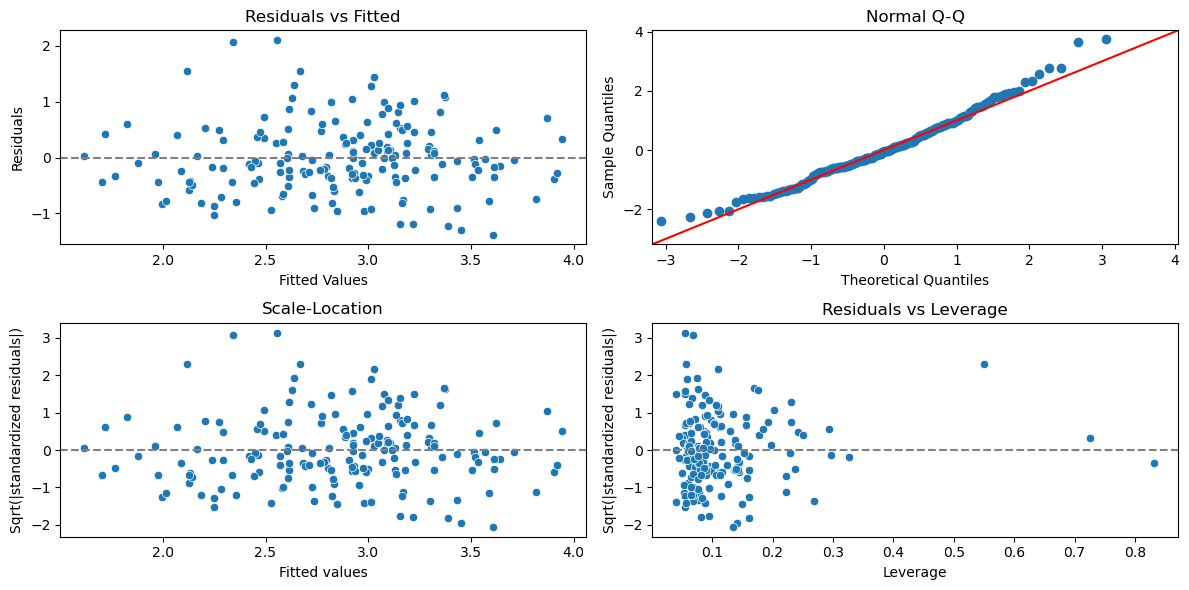

In [27]:
influence = model_lr.get_influence()

res = df.copy()
res['resid'] = model_lr.resid
res['fittedvalues'] = model_lr.fittedvalues
res['resid_std'] = model_lr.resid_pearson
res['leverage'] = influence.hat_matrix_diag

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize = (12,6))
#plt.style.use('seaborn')

# Residual against fitted values.
sns.scatterplot(
    data = res,
    x='fittedvalues', 
    y='resid', 
    ax = ax1
)
ax1.axhline(y=0, color='grey', linestyle='dashed')
ax1.set_xlabel('Fitted Values')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals vs Fitted')

# qqplot
sm.qqplot(
    res['resid'], dist=stats.t, fit=True, line='45',
    ax=ax2
)
ax2.set_title('Normal Q-Q')

# The scale-location plot.
sns.scatterplot(data = res,
    x='fittedvalues', y='resid_std', ax=ax3
)
ax3.axhline(y=0, color='grey', linestyle='dashed')
ax3.set_xlabel('Fitted values')
ax3.set_ylabel('Sqrt(|standardized residuals|)')
ax3.set_title('Scale-Location')

# # Standardized residuals vs. leverage
sns.scatterplot(data = res,
    x='leverage', y='resid_std', ax=ax4
)
ax4.axhline(y=0, color='grey', linestyle='dashed')
ax4.set_xlabel('Leverage')
ax4.set_ylabel('Sqrt(|standardized residuals|)')
ax4.set_title('Residuals vs Leverage')

plt.tight_layout()
plt.show()

## 6. Stepwise regression 
Undertake stepwise regression to determine which variables should be included in the model....

### Model selection: Forward Stepwise Regression

Starting with no covariates, add variables one at a time, trying to minimise the score.
For no particular reason, I am minimising Bayesian Information. (BIC tends to choose models with fewer parameters than AIC).

**Note:** please ignore the now r2 = 0.630 in the stepwise regression....this seems to be something to do with the constant not being included....but I'm not completely sure how to resolve this! Working on it....

In [28]:
variables = list(X.columns)
min_bic = np.inf;
min_variables = None
forward_variables = []

while len(variables): #while there is something to add
    added = None;     #the variable added this turn (or None)
    for v in variables:
        model = sm.OLS(y, X_const[ forward_variables + [v] ]).fit() #fit the model
        if model.bic < min_bic: #check for improvement, record the new best if there is one
            min_variables = forward_variables + [v]
            min_bic = model.bic
            added = v;

    if len(min_variables) == len(forward_variables): break; #no change in best
    forward_variables = min_variables; #start from best so far for next iteration
    variables.remove(added)            #don't check stuff we've already added!
    
    
model = sm.OLS(y, X[ min_variables ]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Cstock25_Mgha   R-squared (uncentered):                   0.630
Model:                            OLS   Adj. R-squared (uncentered):              0.624
Method:                 Least Squares   F-statistic:                              97.17
Date:                Thu, 05 Oct 2023   Prob (F-statistic):                    9.45e-37
Time:                        11:22:31   Log-Likelihood:                         -758.48
No. Observations:                 174   AIC:                                      1523.
Df Residuals:                     171   BIC:                                      1532.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
PAR_mean                0.1324      0.072      1.848      0.066      -0.009       0.274
GHM                    24.0641      6.657      3.615      0.000      10.923      37.205
MEAN_SIG_WAVEHEIGHT     6.9357      2.414      2.873      0.005       2.170      11.701
==============================================================================
Omnibus:                       80.309   Durbin-Watson:                   1.757
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              244.775
Skew:                           1.941   Prob(JB):                     7.04e-54
Kurtosis:                       7.324   Cond. No.                         281.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
min_variables

['PAR_mean', 'GHM', 'MEAN_SIG_WAVEHEIGHT']

### Model selection: Backwards Stepwise Regression

Starting with all the covariates, remove variables one at a time, trying to minimise the score.

In [30]:
variables = list(X.columns)

backward_variables = variables

model = sm.OLS(y, X_const[ backward_variables ]).fit()
min_bic = model.bic;
min_variables = backward_variables

while len(variables): #while there is something to add
    print(backward_variables)
    removed = None;     #the variable added this turn (or None)
    for v in backward_variables:
        mvar = [w for w in backward_variables if w!=v]
        model = sm.OLS(y, X_const[ mvar ]).fit() #fit the model
        if model.bic < min_bic: #check for improvement, record the new best if there is one
            min_variables = mvar
            min_bic = model.bic
            removed = v;

    if len(min_variables) == len(backward_variables): break; #no change in best
    backward_variables = min_variables; #start from best so far for next iteration
    variables.remove(removed)            #don't check stuff we've already added!

model = sm.OLS(y, X_const[ min_variables ]).fit()
model.summary()

['exposure', 'NEAR_DIST', 'mean_area_p3qaa_zSD', 'mean_pressure', 'soil_erosion', 'soil_water', 'soil_silt_pc', 'soil_carbon_stock', 'PAR_mean', 'forest_pc', 'MEAN_SIG_WAVEHEIGHT', 'REGIONAL_SINUOSITY', 'GHM', 'OUTFLOW_DENSITY', 'mean_rain', 'Tidal_range', 'ERODIBILITY', 'TEMP_MOISTURE', 'EMU_PHYSICAL']
['exposure', 'mean_area_p3qaa_zSD', 'mean_pressure', 'soil_erosion', 'soil_water', 'soil_silt_pc', 'soil_carbon_stock', 'PAR_mean', 'forest_pc', 'MEAN_SIG_WAVEHEIGHT', 'REGIONAL_SINUOSITY', 'GHM', 'OUTFLOW_DENSITY', 'mean_rain', 'Tidal_range', 'ERODIBILITY', 'TEMP_MOISTURE', 'EMU_PHYSICAL']
['exposure', 'mean_pressure', 'soil_erosion', 'soil_water', 'soil_silt_pc', 'soil_carbon_stock', 'PAR_mean', 'forest_pc', 'MEAN_SIG_WAVEHEIGHT', 'REGIONAL_SINUOSITY', 'GHM', 'OUTFLOW_DENSITY', 'mean_rain', 'Tidal_range', 'ERODIBILITY', 'TEMP_MOISTURE', 'EMU_PHYSICAL']
['exposure', 'mean_pressure', 'soil_erosion', 'soil_water', 'soil_silt_pc', 'soil_carbon_stock', 'PAR_mean', 'forest_pc', 'MEAN_SIG_WA

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Cstock25_Mgha   R-squared (uncentered):                   0.636
Model:                            OLS   Adj. R-squared (uncentered):              0.628
Method:                 Least Squares   F-statistic:                              74.34
Date:                Thu, 05 Oct 2023   Prob (F-statistic):                    2.56e-36
Time:                        11:22:31   Log-Likelihood:                         -757.06
No. Observations:                 174   AIC:                                      1522.
Df Residuals:                     170   BIC:                                      1535.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
mean_pressure    -0.0006      0.000     -2.770      0.006      -0.001      -0.000
soil_water        0.5229      0.162      3.231      0.001       0.203       0.842
PAR_mean          0.5526      0.170      3.246      0.001       0.217       0.889
GHM              22.0884      6.377      3.464      0.001       9.500      34.677
==============================================================================
Omnibus:                       75.085   Durbin-Watson:                   1.770
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              204.158
Skew:                           1.865   Prob(JB):                     4.65e-45
Kurtosis:                       6.775   Cond. No.                     4.49e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 4.49e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model selection: Other Optimisers

The forward and backward procedures are greedy optimisers, greedy search is usually not the best. You are trying to minimise some function (Bayesian information) so try some other __[Optimiser](https://docs.scipy.org/doc/scipy/reference/optimize.html)__ . The optimiser has to be a very general one because computing the derivatives to too hard! 

I'm going to do a trick where I represent a list of variables as a binary number of fixed width so e.g.<br>
['RM', 'LSTAT', 'CHAS', 'NOX', 'AGE']<br>
v = 0 1 0 0 1 1<br>
gives ['LSTAT', 'NOX', 'AGE']

Let's try with more variables and a fancy optimisation algorithm called basin hopping...

In [31]:
variables = list(X.columns)

def func(v):
    if sum(v) == 0: return 10e10;
    model = sm.OLS(y, X_const[ [var for i,var in enumerate(variables) if v[i] > 0.4] ]).fit()
    return model.bic
      
class MyStep:
   def __init__(self, stepsize=0.5):
       self.rng = np.random.default_rng()
       self.M = len(variables) 
   def __call__(self, x):
       idx = self.rng.integers(0,high=self.M)
       x[idx] = 1 - x[idx]
       return x

v0 = np.ones( len(variables), dtype=np.int8 )

minimizer_kwargs = {"method": "BFGS"}
mystep = MyStep()
print("basin_hopping...")
ret = basinhopping(func, v0, minimizer_kwargs=minimizer_kwargs, niter=200, take_step=mystep)

min_variables = [var for i,var in enumerate(variables) if ret.x[i] > 0.5]
model = sm.OLS(y, X_const[ min_variables ]).fit()
model.summary()

basin_hopping...


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Cstock25_Mgha   R-squared (uncentered):                   0.627
Model:                            OLS   Adj. R-squared (uncentered):              0.620
Method:                 Least Squares   F-statistic:                              95.75
Date:                Thu, 05 Oct 2023   Prob (F-statistic):                    2.08e-36
Time:                        11:22:35   Log-Likelihood:                         -759.28
No. Observations:                 174   AIC:                                      1525.
Df Residuals:                     171   BIC:                                      1534.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
exposure      -9.099e-05   3.88e-05     -2.343      0.020      -0.000   -1.43e-05
mean_pressure     0.0002    1.8e-05     12.418      0.000       0.000       0.000
TEMP_MOISTURE     6.4792      1.773      3.654      0.000       2.979       9.979
==============================================================================
Omnibus:                       67.903   Durbin-Watson:                   1.752
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              160.117
Skew:                           1.754   Prob(JB):                     1.70e-35
Kurtosis:                       6.127   Cond. No.                     1.26e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.26e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Zheng-Loh Model Selection

Simple and it's supposed to work. Zheng and Loh showed that, under appropriate conditions, this method
chooses the true model with probability tending to one as the sample size increases.

1. Fit everything and compute the Wald test statistic for H0 : $c_j = 0$ versus H1 : $c_j = 0$ (I think this is more or less just the t score???)
2. Sort

In [32]:
variables = list(X.columns)
model = sm.OLS(y, X_const[ variables ]).fit()

sigma_2 = model.mse_resid
def zheng_loh_score(v):
    m = sm.OLS(y, X_const[ v ]).fit()
    #print(m.ssr, len(v)*sigma_2*np.log(m.nobs), len(v), sigma_2, m.nobs)
    return m.ssr + len(v)*m.mse_resid*np.log(m.nobs)

min_zl = np.inf;
min_variables = []
zl_variables = []
for col, t in model.tvalues.abs().sort_values(ascending=False).items(): 
    zl_score = zheng_loh_score(zl_variables + [col])

    if zl_score < min_zl:
        min_zl = zl_score
        min_variables = [v for v in zl_variables] + [col]
        
    zl_variables += [col]

model = sm.OLS(y, X_const[ min_variables ]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Cstock25_Mgha   R-squared (uncentered):                   0.625
Model:                            OLS   Adj. R-squared (uncentered):              0.619
Method:                 Least Squares   F-statistic:                              95.19
Date:                Thu, 05 Oct 2023   Prob (F-statistic):                    2.84e-36
Time:                        11:22:35   Log-Likelihood:                         -759.60
No. Observations:                 174   AIC:                                      1525.
Df Residuals:                     171   BIC:                                      1535.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
GHM           23.4127      5.484      4.269      0.000      12.587      34.239
exposure   -8.994e-05   3.88e-05     -2.316      0.022      -0.000   -1.33e-05
soil_water     0.1944      0.029      6.709      0.000       0.137       0.252
==============================================================================
Omnibus:                       72.971   Durbin-Watson:                   1.759
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              190.725
Skew:                           1.830   Prob(JB):                     3.84e-42
Kurtosis:                       6.594   Cond. No.                     1.60e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.6e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
min_variables

['GHM', 'exposure', 'soil_water']

## 7. Boosted Regression Tree

Multiple linear regression shows that some variables are predictive but the r2 score is low. Now to see if ML methods can create a more predictive model. First run boosted regression trees and tune parameters to optimise parameters

Below useful infographic to remember what each parameter does....

![](https://www.analyticsvidhya.com/wp-content/uploads/2016/02/tree-infographic.png)

In [34]:
#create the empty model
reg = GradientBoostingRegressor(n_estimators  = 20, 
                                max_depth = 5, 
                                learning_rate = 0.1, 
                                min_samples_split = 2)
#fit the model
reg.fit(X_train, y_train)
# predict the test-set 
y_pred = reg.predict(X_test)
#compute test-set labels
mse = MSE(y_test, y_pred)
rmse = mse**(1/2)
print('The RMSE (root of the squared mean error is', rmse)
print('accuracy on training set: {:.3f}'.format(reg.score(X_train, y_train)))
print('accuracy on test set: {:.3f}'.format(reg.score(X_test, y_test)))

The RMSE (root of the squared mean error is 21.488386405525727
accuracy on training set: 0.848
accuracy on test set: -0.033


The RMSE measures on average how much the models predictions differ from the actual labels.  The R2 on training and test set suggests it is significantly overfitting on the training set and not performing on the test set. Aiming to have a high accuracy on training set with a high accuracy on test set - current looks like overfitting on training set and poor fit on test set. 

### Features importance

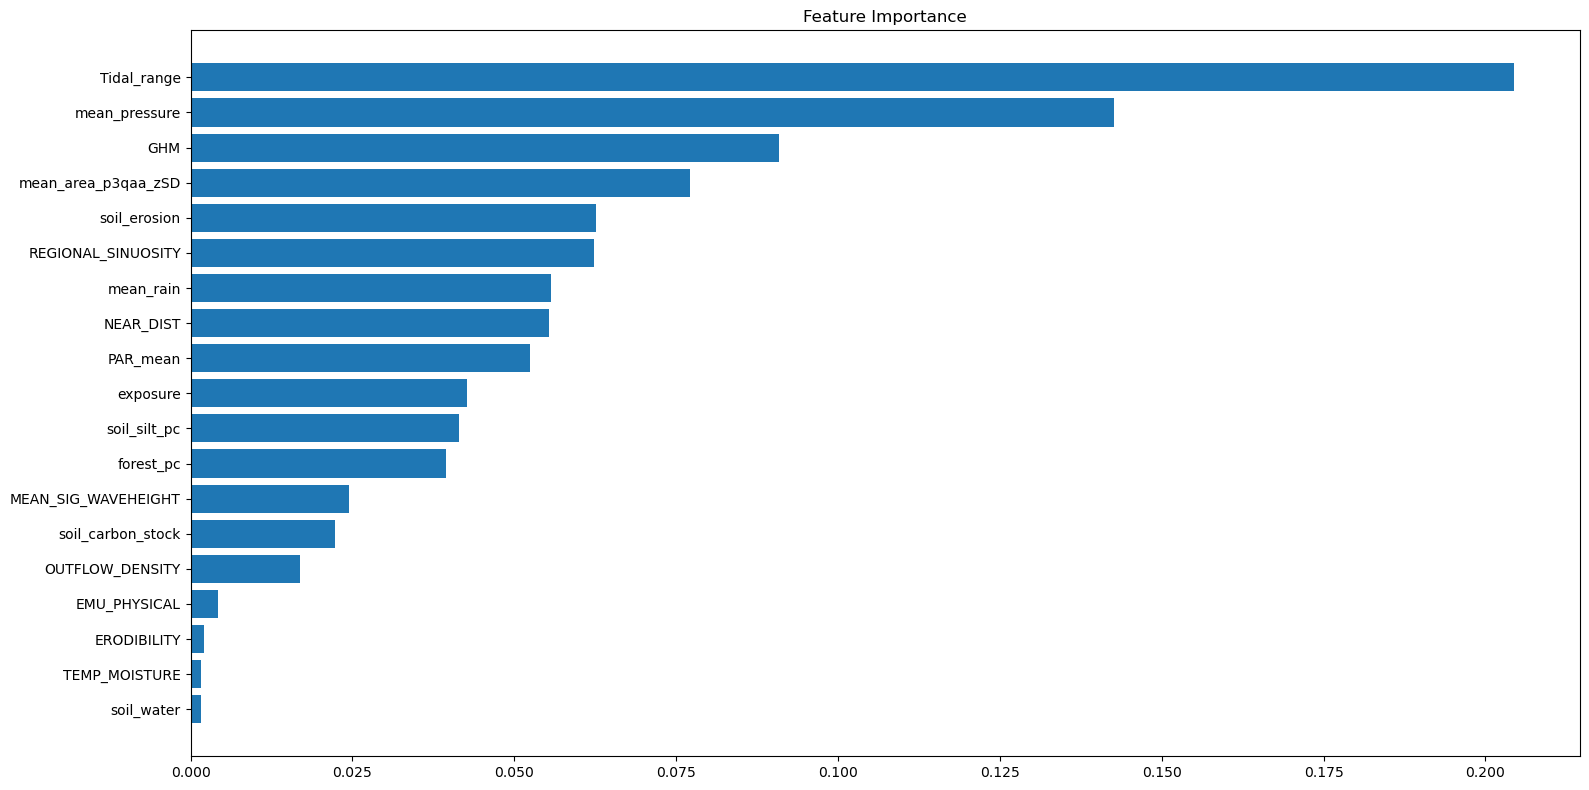

In [35]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])+ .5

fig = plt.figure(figsize = (16,8))
plt.barh(pos, feature_importance[sorted_idx], align = 'center')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')
result = permutation_importance(reg, X_test, y_test, n_repeats = 100, random_state = 42, n_jobs = 2)
sorted_idx = result.importances_mean.argsort()
fig.tight_layout()
plt.show()

## 8. Decision Tree Regressor

To improve on the BRT, run a decision tree regressor <br> Resources:  https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

In [36]:
#Create a Gaussian Classifier
regr = DecisionTreeRegressor(max_depth = 5, min_samples_leaf = 3, random_state =156)
#Train the model using the training sets
regr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=3, random_state=156)

In [37]:
print('R2 score on full dataset: ', regr.score(X, y))
print('R2 score on training dataset only: ', regr.score(X_train, y_train))
print('R" score on test dataset: ', regr.score(X_test, y_test))

R2 score on full dataset:  0.4155377114725173
R2 score on training dataset only:  0.5098109246598304
R" score on test dataset:  0.08791864340370359


Similarly to BRT model, fitting to training dataset but not performing on test dataset. Below visualise first bit of tree....

### Visualise Tree

In [38]:
#visualise what the tree is currently doing
print(tree.export_text(regr))

|--- feature_15 <= 0.17
|   |--- feature_16 <= 2.50
|   |   |--- feature_8 <= 52.53
|   |   |   |--- feature_1 <= 368.54
|   |   |   |   |--- value: [7.74]
|   |   |   |--- feature_1 >  368.54
|   |   |   |   |--- value: [10.80]
|   |   |--- feature_8 >  52.53
|   |   |   |--- feature_3 <= 101438.25
|   |   |   |   |--- feature_2 <= 3.64
|   |   |   |   |   |--- value: [5.19]
|   |   |   |   |--- feature_2 >  3.64
|   |   |   |   |   |--- value: [3.98]
|   |   |   |--- feature_3 >  101438.25
|   |   |   |   |--- value: [6.94]
|   |--- feature_16 >  2.50
|   |   |--- feature_11 <= 1.48
|   |   |   |--- feature_11 <= 1.11
|   |   |   |   |--- value: [6.19]
|   |   |   |--- feature_11 >  1.11
|   |   |   |   |--- value: [13.81]
|   |   |--- feature_11 >  1.48
|   |   |   |--- value: [22.37]
|--- feature_15 >  0.17
|   |--- feature_15 <= 0.32
|   |   |--- value: [57.42]
|   |--- feature_15 >  0.32
|   |   |--- feature_3 <= 101741.77
|   |   |   |--- feature_14 <= 0.11
|   |   |   |   |--- 

In [39]:
from sklearn.tree import export_graphviz
export_graphviz(
    regr,
    out_file = "random_tree.dot",
    rounded = True
)

## 9. Random Forest Regressor 

#### Choose best parameters with GridSearch

Do gridsearch to find optimum parameters to fine tune random forest regressor model to improve scores

In [40]:
#Use scikit_learn metrics module for accuracy calculation
param_grid = [
    {'n_estimators':[2,3,4,6,8,9,10,12], 'max_features':[2,4,6,8,9,10]},
    {'bootstrap':[False], 'n_estimators':[3,10,15,20], 'max_features': [2,3,4]},
    #{'n_estimators':[3,10,15,20], 'max_features': [2,3,4], 'min_samples_leaf': [2,3,4,5,6,7], 'max_depth' : [2,3,4,5,6]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring = 'neg_mean_squared_error',
                           return_train_score = True)

grid_search.fit(X, y)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8, 9, 10],
                          'n_estimators': [2, 3, 4, 6, 8, 9, 10, 12]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10, 15, 20]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [41]:
grid_search.best_estimator_

RandomForestRegressor(max_features=2, n_estimators=10)

Update regression model with these parameters 

In [42]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    pass
    #print(np.sqrt(-mean_score), params)

Update forest regressor with best estimators identified above to re-run analysis

In [48]:
#Create a Gaussian Classifier
forest_reg = RandomForestRegressor(n_estimators = 10, 
                                   max_features = 2, 
                                   #max_depth = 4, 
                                   #min_samples_leaf = 7, 
                                   random_state =42)
#Train the model using the training sets
forest = forest_reg.fit(X_train, y_train)
sg_predictions = forest.predict(X_test)

#evaluate
sg_mse = mean_squared_error(y_test, sg_predictions)
sg_rmse = np.sqrt(sg_mse)
r2_all = forest.score(X, y)
r2 = forest.score(X_train,y_train)
r2_test = forest.score(X_test, y_test)
print('RMSE: ', sg_rmse)
print('R2 on whole dataset: ', r2_all)
print('R2 on train set: ', r2)
print('R2 on test set: ', r2_test)

RMSE:  20.863731105039253
R2 on whole dataset:  0.6510617559467307
R2 on train set:  0.8320488006613895
R2 on test set:  0.025995833583010053


**Still underperforming on test dataset. Next view the relative importance of each feature**

### Features Importance

In [49]:
#relative importance of each attribute
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importance_names = dict(zip(X.columns.tolist(), feature_importances))
{k: v for k, v in sorted(feature_importance_names.items(), reverse = True, key=lambda item: item[1])}

{'mean_rain': 0.10126620962586508,
 'mean_area_p3qaa_zSD': 0.08552534041719287,
 'exposure': 0.07430600073771966,
 'MEAN_SIG_WAVEHEIGHT': 0.07174434566337844,
 'soil_erosion': 0.07003145743269795,
 'mean_pressure': 0.06100722452956905,
 'Tidal_range': 0.058282484459609284,
 'REGIONAL_SINUOSITY': 0.05706177746794577,
 'EMU_PHYSICAL': 0.0558438833467898,
 'GHM': 0.05251535283245321,
 'soil_silt_pc': 0.05018512313547768,
 'NEAR_DIST': 0.04185859970066079,
 'forest_pc': 0.03825992042217128,
 'soil_water': 0.03796656196654333,
 'TEMP_MOISTURE': 0.03755285505078827,
 'soil_carbon_stock': 0.03750676442734872,
 'OUTFLOW_DENSITY': 0.03554793791938181,
 'PAR_mean': 0.024212501755428502,
 'ERODIBILITY': 0.009325659108978545}

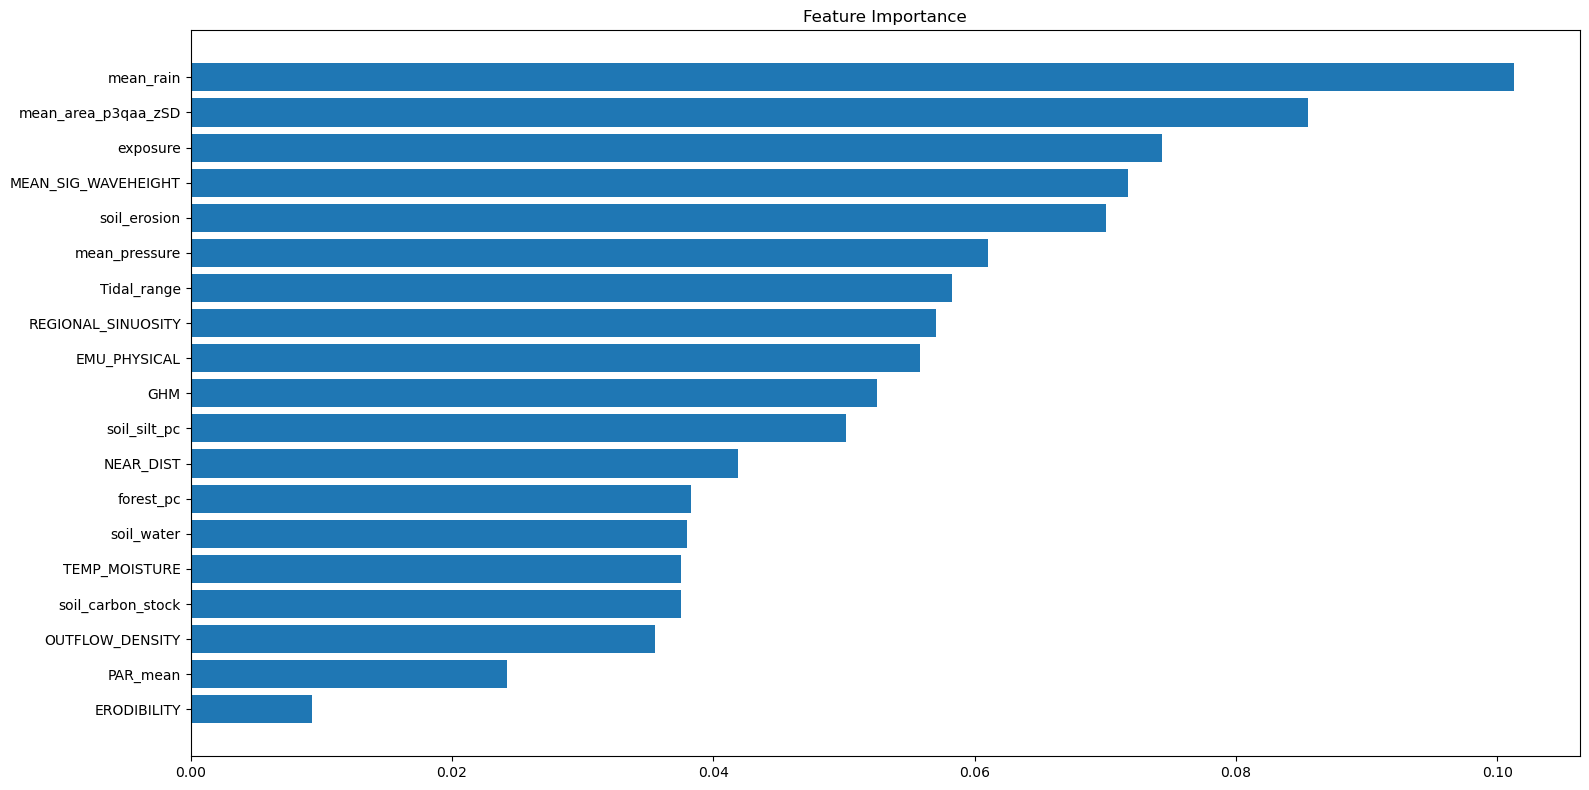

In [50]:
sorted_idx = np.argsort(feature_importances)
pos = np.arange(sorted_idx.shape[0])+ .5

fig = plt.figure(figsize = (16,8))
plt.barh(pos, feature_importances[sorted_idx], align = 'center')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')
result = permutation_importance(grid_search, X, y, n_repeats = 100, random_state = 42, n_jobs = 2)
sorted_idx = result.importances_mean.argsort()
fig.tight_layout()
plt.show()

### Visualise the tree

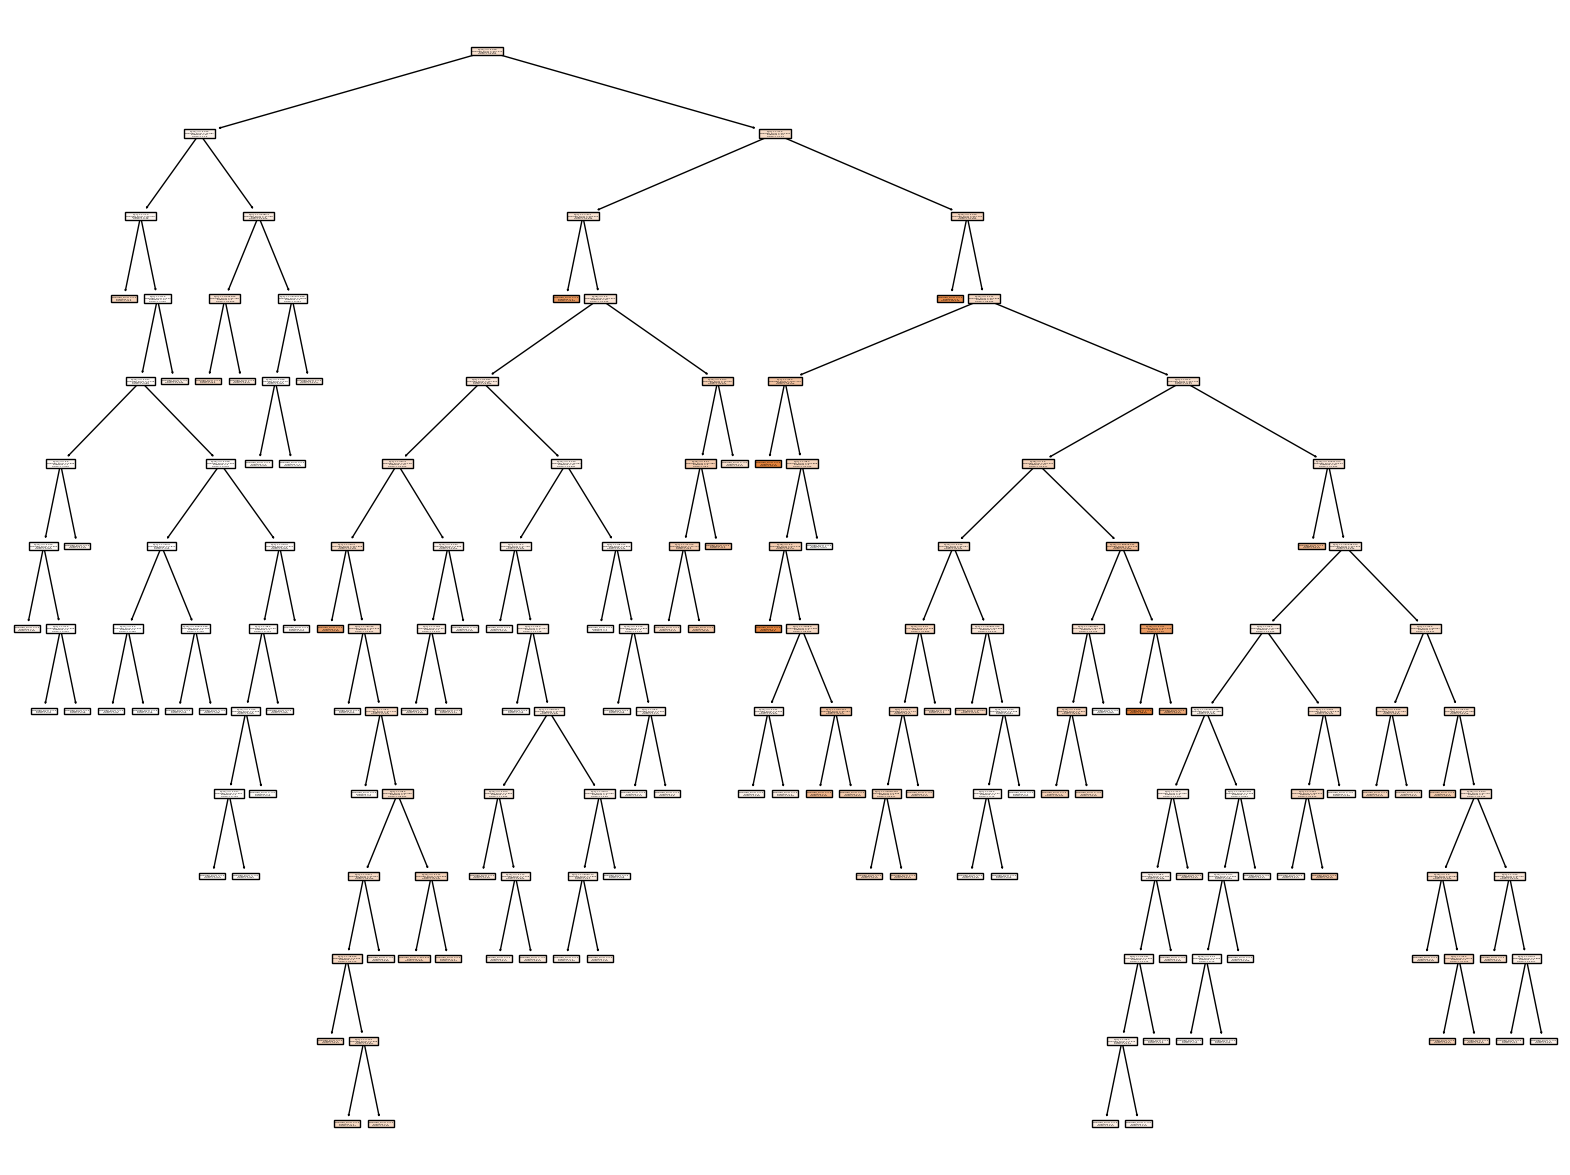

In [51]:
plt.figure(figsize=(20,15))
plot_tree(forest_reg.estimators_[0], filled = True)
plt.savefig('rf_tree_plot.png')
plt.show()

## 10 Summary

The linear multiple regression gives a r2 of ~0.3 but the BRTs and Random Forests seem unable to perform on the training dataset which suggests it is overfitting on the training dataset. Tuning parameters to reduce overfitting does not seem to create any improvement on it's performance on unseen data. How can this be improved??!